In [2]:
### IMPOTRED PACKAGES

In [3]:
import pandas as pd
import numpy as np
import scipy
import math
import matplotlib.pyplot as plt
from sklearn.covariance import GraphLassoCV
from sklearn.metrics import mutual_info_score
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import signal

In [4]:
### DATA LOADING

In [5]:
# load the stock data:

df1  = pd.read_csv("path/stock_exchange/detrended-log.csv", sep=',', parse_dates=True, index_col='date')

df1 = df1.astype(float)

'''
par = 10
for col in list(df1):
    df1['ma'] = df1[col].rolling(par,center=False).mean().bfill()
    df1[col] = df1[col]-df1['ma']
 
df1 = df1.drop('ma', 1)
df1 = df1.drop('population', 1)
print df1
'''

data1  = df1.values
Nvars  = data1.shape[1]

labels_Glasser  = list(df1)

df1 = df1[labels_Glasser[0:100]]

print (df1)

                 ABT       AET       APD       AXP       AIG      AMGN  \
date                                                                     
1993-12-15 -0.009306 -0.020643 -0.007888 -0.028514  0.004442  0.000000   
1993-12-16 -0.008465 -0.001576 -0.008465 -0.008725 -0.001426  0.010664   
1993-12-17  0.013514  0.009558  0.005267  0.008725  0.004350  0.000000   
1993-12-20  0.012533  0.011100  0.003198  0.015793  0.002955 -0.016081   
1993-12-21  0.000000 -0.017421  0.000000  0.019740 -0.007304  0.023243   
1993-12-22  0.017379 -0.003237 -0.005828 -0.011273  0.013188  0.005272   
1993-12-23  0.008968 -0.011297  0.000000  0.008459 -0.017716  0.020855   
1993-12-27  0.012038  0.004792  0.019465  0.015288  0.007337  0.037172   
1993-12-28 -0.008022  0.022397 -0.000441 -0.019493  0.000000  0.031041   
1993-12-29  0.000000  0.009476 -0.019538 -0.004254 -0.001384  0.022248   
1993-12-30 -0.017072 -0.009476 -0.013914  0.008459  0.000000 -0.012637   
1993-12-31  0.013056  0.003169  0.0000

In [6]:
### PEARSON CORRELATION

In [7]:
# [2] define partial correlation through OLS:
from scipy import stats, linalg
def partial_corr(C):
    """
    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
    for the remaining variables in C.
    Parameters
    ----------
    C : array-like, shape (n, p)
        Array with the different variables. Each column of C is taken as a variable
    Returns
    -------
    P : array-like, shape (p, p)
        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
        for the remaining variables in C.
    """

    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]

            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)

            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr

    return P_corr

In [8]:
# [1] PEARSON'S R:
pearsonr        = np.zeros((Nvars,Nvars))
pearsonr_p      = np.zeros((Nvars,Nvars))
for ind1 in range(Nvars):
    for ind2 in range(Nvars):
        (pearsonr[ind1,ind2],pearsonr_p[ind1,ind2]) = scipy.stats.pearsonr(data1[:,ind1], data1[:,ind2])
        



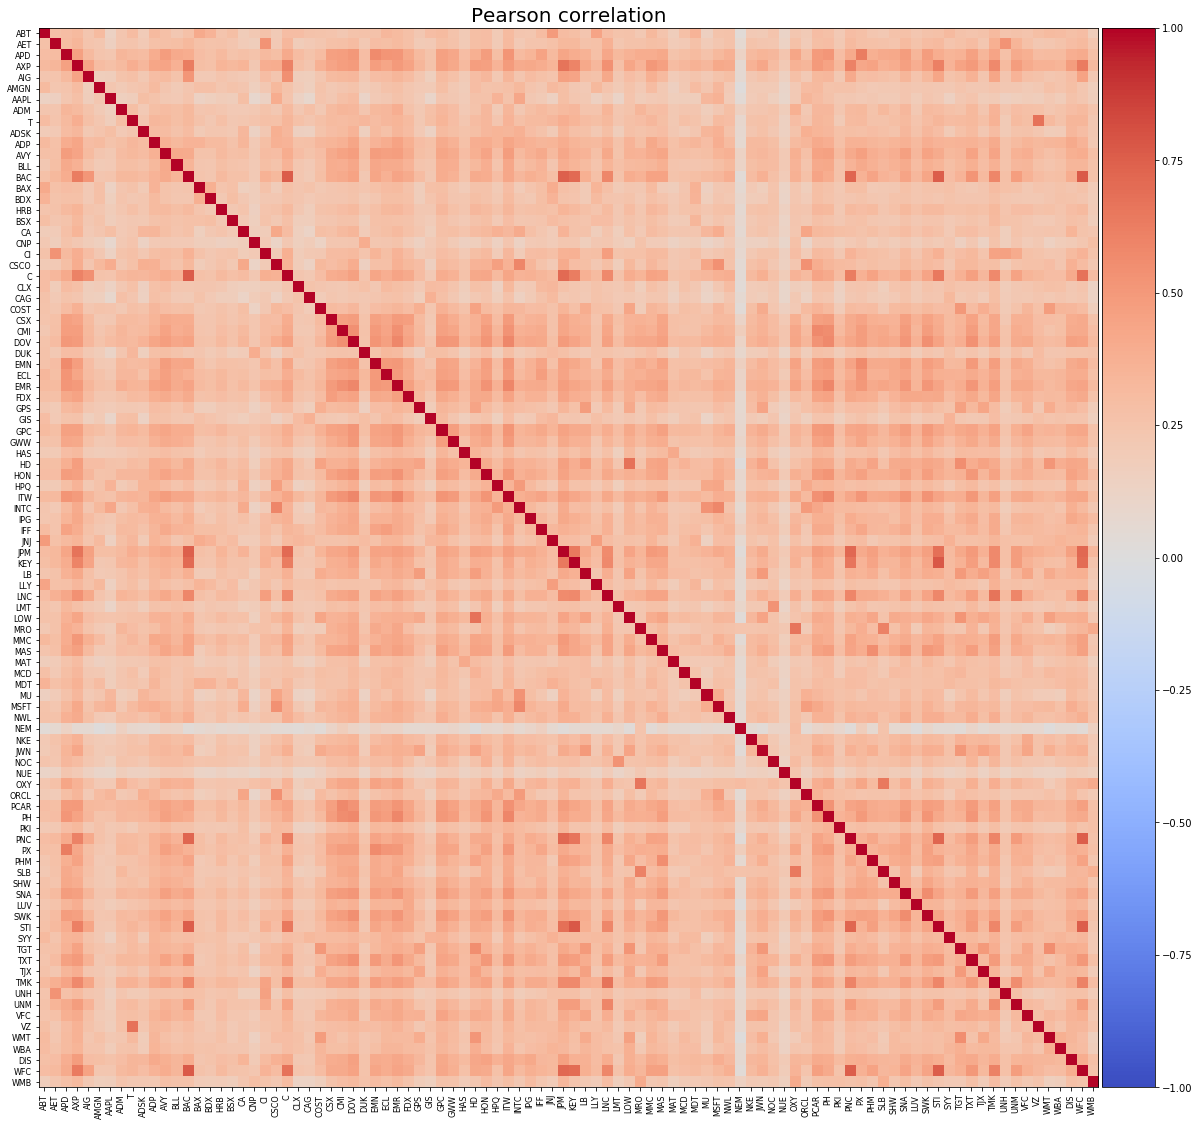

In [9]:
# [1] PEARSON'S R - PLOTTING FUNCTIONAL CONNECTIVITY:
f = plt.figure(figsize=(20,20))
ax = plt.gca()
im = plt.imshow(pearsonr, clim=[-0.5,0.5],cmap='coolwarm')
im = plt.imshow(pearsonr, clim=[-1,1],cmap='coolwarm')
plt.xticks(np.arange(len(labels_Glasser)), labels_Glasser, rotation='vertical', fontsize=8)
plt.yticks(np.arange(len(labels_Glasser)), labels_Glasser, fontsize=8)
plt.title('Pearson correlation', fontsize=20)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

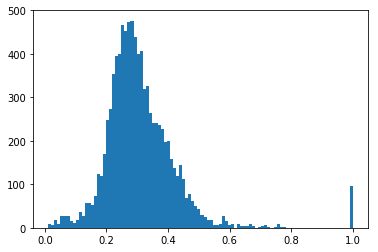

In [11]:
plt.figure()
n, bins, _ = plt.hist(pearsonr.flatten(), bins = 100)
plt.show()

In [13]:
### PARTIAL CORRELATION 

In [12]:
# [2A] PARTIAL CORRELATION THROUGH OLS REGRESSION:
# warning: this one is slooooow:
# partial_correlation1 = partial_corr(data)

# [2B] PARTIAL CORRELATION THROUGH INVERSE COVARIANCE:
# partial_correlation = partial_corr(data)
covariance_matrix = np.cov(np.transpose(data1))
inv_cov = np.linalg.inv(covariance_matrix)
partial_correlation2 = np.zeros((Nvars,Nvars))
for ind1 in range(Nvars):
    for ind2 in range(Nvars):
        partial_correlation2[ind1,ind2] = - inv_cov[ind1,ind2]/np.sqrt((inv_cov[ind1,ind1])*(inv_cov[ind2,ind2]))

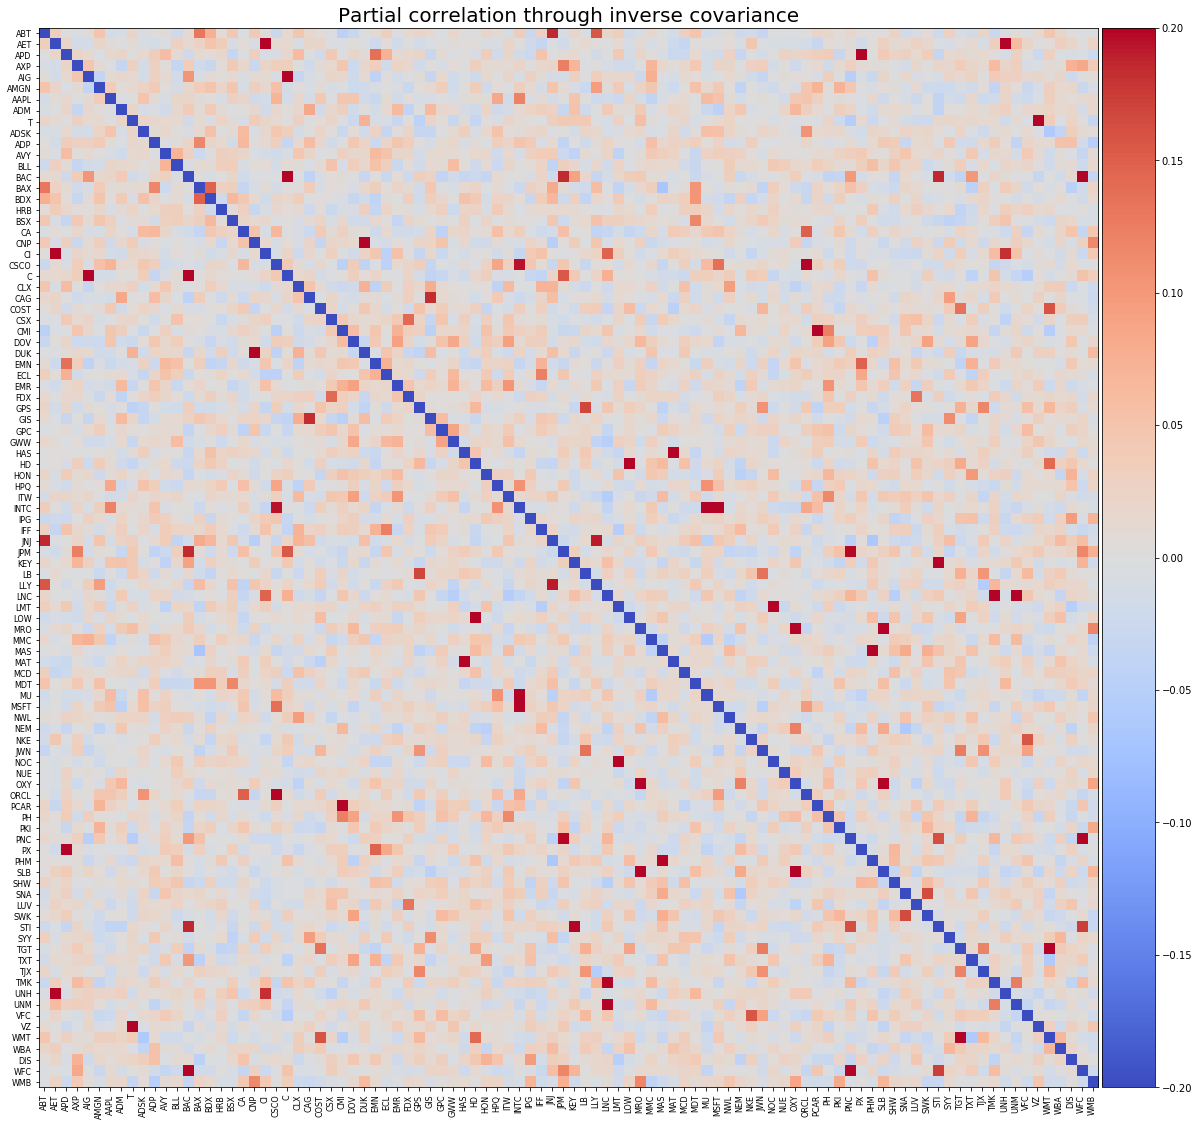

In [13]:
#[2B] PARTIAL CORRELATION THROUGH INVERSE COVARIANCE:
f = plt.figure(figsize=(20,20))
ax = plt.gca()
#im = plt.imshow(partial_correlation2, clim=[-0.5,0.5],cmap='coolwarm')
im = plt.imshow(partial_correlation2, clim=[-0.2,0.2],cmap='coolwarm')
plt.xticks(np.arange(len(labels_Glasser)), labels_Glasser, rotation='vertical', fontsize=8)
plt.yticks(np.arange(len(labels_Glasser)), labels_Glasser, fontsize=8)
plt.title('Partial correlation through inverse covariance', fontsize=20)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

In [ ]:
### SAVING FIGURES

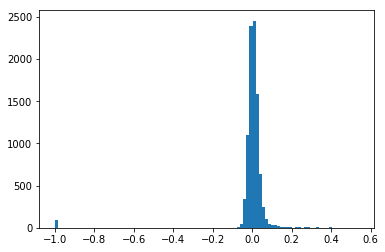

In [14]:
plt.figure()
n, bins, _ = plt.hist(partial_correlation2.flatten(), bins = 100)
plt.show()

In [17]:
### COHERENCE

In [18]:
# [03] an example of a coherence computed on an exemplary fMRI dataset:
# source: http://nipy.org/nitime/examples/multi_taper_coh.html
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.mlab import csv2rec
import scipy.stats.distributions as dist
from scipy import fftpack

import nitime
from nitime.timeseries import TimeSeries

from nitime import utils
import nitime.algorithms as alg
import nitime.viz
from nitime.viz import drawmatrix_channels
from nitime.analysis import CoherenceAnalyzer, MTCoherenceAnalyzer

Networkx is not available. Some visualization tools might not work
 To download networkx: http://networkx.lanl.gov/


C:\Aplikacje\Miniconda-python\version_32\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [21]:

data_rec = csv2rec("path/stock_exchange/detrended-log1-1.csv")


TR = 1 # 1/fs = the sampling frequency; TR for our resting state data was 0.72[s] 
f_ub = 10 #lowpass frequency upper band  
f_lb = 0 #highpass  frequency lower band


labels = np.array(data_rec.dtype.names)

# print (labels_names)
# print (data_rec)
print(labels)
print (data_rec)
nseq = len(labels)
n_samples = data_rec.shape[0]
# print ('N-SAMPLES TO: ', n_samples)
data = np.zeros((nseq, n_samples))

#DO czego jest ta pętla? co ona robi???
for n_idx, label in enumerate(labels):
    data[n_idx] = data_rec[label]

pdata = utils.percent_change(data)
print (pdata)

['abt' 'aet' 'apd' 'axp' 'aig' 'amgn' 'aapl' 'adm' 't' 'adsk' 'adp' 'avy'
 'bll' 'bac' 'bax' 'bdx' 'hrb' 'bsx' 'ca' 'cnp' 'ci' 'csco' 'c' 'clx' 'cag'
 'cost' 'csx' 'cmi' 'dov' 'duk' 'emn' 'ecl' 'emr' 'fdx' 'gps' 'gis' 'gpc'
 'gww' 'has' 'hd' 'hon' 'hpq' 'itw' 'intc' 'ipg' 'iff' 'jnj' 'jpm' 'key'
 'lb' 'lly' 'lnc' 'lmt' 'low' 'mro' 'mmc' 'mas' 'mat' 'mcd' 'mdt' 'mu'
 'msft' 'nwl' 'nem' 'nke' 'jwn' 'noc' 'nue' 'oxy' 'orcl' 'pcar' 'ph' 'pki'
 'pnc' 'px' 'phm' 'slb' 'shw' 'sna' 'luv' 'swk' 'sti' 'syy' 'tgt' 'txt'
 'tjx' 'tmk' 'unh' 'unm' 'vfc' 'vz' 'wmt' 'wba' 'dis' 'wfc' 'wmb']
[ (-0.00930627, -0.02064286, -0.00788758, -0.02851434,  0.00444181,  0.        ,  0.02175498,  0.05491418, -0.00332442,  0.        , -0.00968932, -0.00418161,  0.01768259, -0.00563988, -0.01089781,  0.        ,  0.00853504, -0.0349686 , -0.02703503,  0.00732854, -0.00756162,  0.        , -0.02489064, -0.00938812,  0.        ,  0.02582464, -0.0040172 , -0.03729658, -0.00238354,  0.00229245, -0.02225306, -0.00614811,

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32]


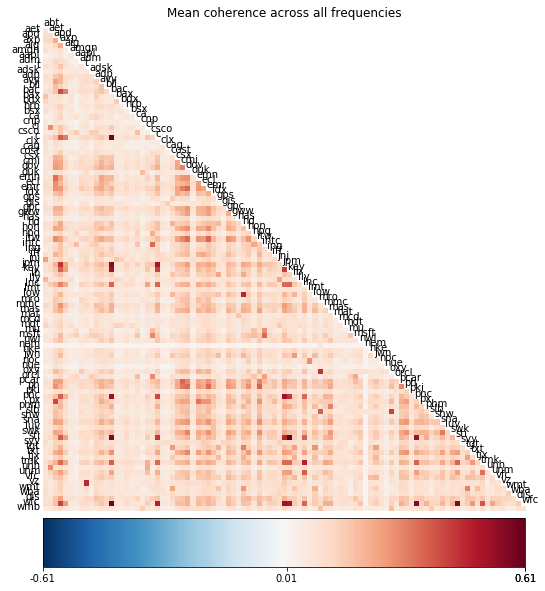

In [22]:
T = TimeSeries(pdata, sampling_interval=TR, time_unit = 's')
# T.metadata['label'] = labels_names
T.metadata['label'] = labels
# T.metadata = labels

C3 = CoherenceAnalyzer(T)
freq_idx = np.where((C3.frequencies > f_lb) * (C3.frequencies < f_ub))[0]
print (freq_idx)
#Extract the coherence and average across these frequency bands:
coh = np.mean(C3.coherence[:, :, freq_idx], -1)  # Averaging on the last dimension
fig03 = drawmatrix_channels(coh,
                            labels,
                            size=[10., 10.],
                            color_anchor=0,
                            title='Mean coherence across all frequencies')
plt.show()


